## Name: Harshvardhan Tyagi
## Student ID : 8856516

In [99]:
# Importing the Pandas library and aliasing it as 'pd' for easier reference
import pandas as pd

# Importing the NumPy library and aliasing it as 'np' for easier reference
import numpy as np


Obtain the Data

Download the BIRDS 525 SPECIES dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks.

Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (ImageDataGenerator.flow_from_directory).

For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.

In [100]:
# Reading a CSV file named "birds.csv" from the specified path "D:/birds.csv"
# and storing the data in a Pandas DataFrame called 'df'
df = pd.read_csv("D:/birds.csv")

In [101]:
# I find the top 3 most frequent labels in the 'labels' column of the DataFrame 'df'
# First, I count the occurrences of each label using 'value_counts()'
# Then, I select the top 3 counts using 'nlargest(3)'
# Finally, I extract the index labels of these top 3 counts and convert them into a Python list using 'index.tolist()'
top_3_labels = df['labels'].value_counts().nlargest(3).index.tolist()


In [102]:
# I set the paths for the training, testing, and validation datasets
train_path = 'D:/train'
test_path = 'D:/test'
validate_path = 'D:/valid'

# I import the necessary 'os' module to handle directory operations
import os

# Function to count images per label in a given directory
def images_per_label(directory, top_labels):
    # I initialize empty lists to store labels and their corresponding image counts
    labels = []
    image_counts = []

    # I traverse through the directory and its subdirectories using 'os.walk()'
    for root, dirs, files in os.walk(directory):
        # For each top label of interest
        for label in top_labels:
            # I create the path to the current label within the directory
            label_path = os.path.join(root, label)
            
            # I check if the label directory exists within the current path
            if os.path.isdir(label_path):
                # I count the number of images with specific extensions ('.jpg', '.jpeg', '.png')
                # by filtering files that end with these extensions
                image_files = [file for file in os.listdir(label_path) if file.endswith(('.jpg', '.jpeg', '.png'))]
                num_images = len(image_files)
                
                # I append the label and its corresponding image count to the lists
                labels.append(label)
                image_counts.append(num_images)

    # I return the lists containing labels and their respective image counts
    return labels, image_counts

# I call the function to count images per label in the training dataset using top 3 labels
train_labels, train_image_counts = images_per_label(train_path, top_3_labels)

# I display the top 3 labels found in the training set
print("Top 3 labels in the training set:")
print(train_labels)



Top 3 labels in the training set:
['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


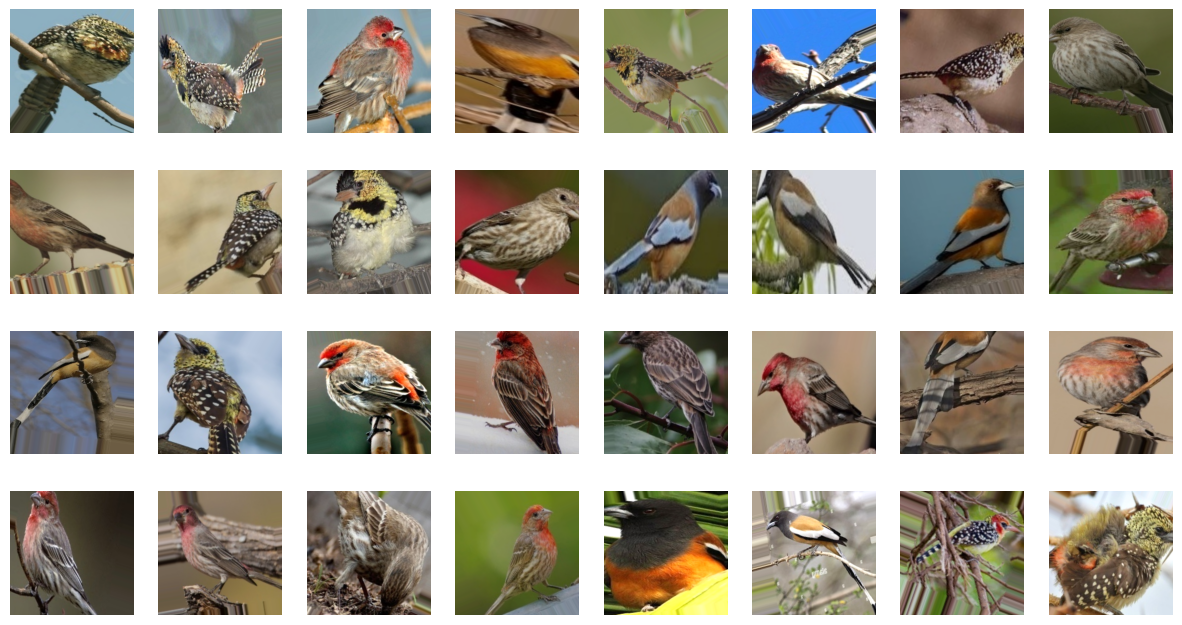

In [105]:
# I import necessary modules from TensorFlow for image preprocessing and model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# I set up data augmentation for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling pixel values to a range of [0, 1]
    rotation_range=30,  # Random rotation of the image by a maximum of 30 degrees
    width_shift_range=0.1,  # Shifting the width of the image by a maximum of 10%
    height_shift_range=0.1,  # Shifting the height of the image by a maximum of 10%
    brightness_range=[0.8, 1.2],  # Random brightness adjustment between 0.8 and 1.2
    shear_range=0.2,  # Shear intensity (shear mapping) with a maximum of 0.2
    zoom_range=0.2,  # Random zooming inside the image by a maximum of 20%
    horizontal_flip=True,  # Randomly flipping images horizontally
    fill_mode='nearest'  # Filling in newly created pixels after rotation or width/height shift
)

# I set up data normalization for the validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)

# I create a generator for the training dataset using flow_from_directory method
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the training dataset
    target_size=(224, 224),  # Resizing images to 224x224 pixels
    batch_size=32,  # Generating batches of 32 images at a time
    class_mode='categorical',  # Generating categorical labels
    classes=train_labels  # Specifying the labels based on the earlier extracted 'train_labels'
)

# I create a generator for the validation dataset using flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(
    validate_path,  # Path to the validation dataset
    target_size=(224, 224),  # Resizing images to 224x224 pixels
    batch_size=32,  # Generating batches of 32 images at a time
    class_mode='categorical',  # Generating categorical labels
    classes=train_labels  # Specifying the labels based on the earlier extracted 'train_labels'
)

# I import the necessary module for visualization
import matplotlib.pyplot as plt

# I retrieve a batch of augmented images along with their labels from the 'train_generator'
augmented_images, _ = train_generator.next()

# I display the augmented images using matplotlib
fig, axes = plt.subplots(4, 8, figsize=(15, 8))  # Creating a grid of 4 rows and 8 columns for image display
axes = axes.flatten()  # Flattening the axes array to iterate easily through subplots

# Loop through each augmented image and its corresponding axis for display
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)  # Display the image on the current axis
    ax.axis('off')  # Turn off axis labels and ticks for better visualization

plt.show()  # Show the grid of augmented images



Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [84]:
# I import necessary modules from TensorFlow for building the model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# I load the pre-trained VGG16 model without its top layer (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# I add custom classification layers on top of the VGG16 base model
x = base_model.output
x = Flatten()(x)  # Flattening the output of the base model
x = Dense(256, activation='relu')(x)  # Adding a dense layer with 256 neurons and ReLU activation
x = Dropout(0.5)(x)  # Adding a dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer with 3 neurons for 3 classes and softmax activation

# I create a new model with VGG16 as the base and the added custom layers for classification
model = Model(inputs=base_model.input, outputs=predictions)

# I freeze the layers of the pre-trained VGG16 model up to a certain point to retain its weights
for layer in base_model.layers:
    layer.trainable = False  # Setting pre-trained layers as non-trainable

# I compile the model with specific configurations for training
model.compile(optimizer=Adam(lr=0.0001),  # Using the Adam optimizer with a learning rate of 0.0001
              loss='categorical_crossentropy',  # Using categorical cross-entropy loss for multi-class classification
              metrics=['accuracy'])  # Evaluating model performance based on accuracy during training




In [82]:
# Training the model using the 'fit' method with the training and validation generators
# 'epochs=10' specifies the number of training epochs
# 'validation_data=validation_generator' specifies the validation dataset to evaluate the model's performance
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
24/24 [==============================] - 47s 2s/step - loss: 0.3202 - accuracy: 0.8844 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 46s 2s/step - loss: 0.2626 - accuracy: 0.9019 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 43s 2s/step - loss: 0.2068 - accuracy: 0.9301 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 44s 2s/step - loss: 0.1488 - accuracy: 0.9449 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 52s 2s/step - loss: 0.1930 - accuracy: 0.9261 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 62s 2s/step - loss: 0.1538 - accuracy: 0.9462 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 43s 2s/step - loss: 0.1281 - accuracy: 0.9610 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/10
24/24 [==

Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

In [106]:
# I import necessary modules from sklearn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import numpy as np

# I create a test data generator similar to the training and validation generators
test_generator = train_datagen.flow_from_directory(
    test_path,  # Path to the test dataset
    target_size=(224, 224),  # Resizing images to 224x224 pixels
    batch_size=32,  # Generating batches of 32 images at a time
    class_mode='categorical',  # Generating categorical labels
    classes=train_labels  # Specifying the labels based on the earlier extracted 'train_labels'
)

# I extract the true labels from the test generator
test_labels = test_generator.classes

# I generate predictions using the trained model on the test dataset
predictions = model.predict_generator(test_generator)

# I evaluate the model's performance on the test dataset
eval_results = model.evaluate_generator(test_generator)
accuracy = eval_results[1]  # Extracting accuracy from evaluation results
loss = eval_results[0]  # Extracting loss from evaluation results

# I extract predicted labels by finding the index of the highest probability in predictions
predicted_labels = np.argmax(predictions, axis=1)

# I generate a classification report showing precision, recall, and F1-score
report = classification_report(test_labels, predicted_labels)

# I generate a confusion matrix to evaluate the model's performance
conf_matrix = confusion_matrix(test_labels, predicted_labels)



Found 15 images belonging to 3 classes.


C:\Users\dell\AppData\Local\Temp\ipykernel_20748\1770424717.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)
C:\Users\dell\AppData\Local\Temp\ipykernel_20748\1770424717.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  eval_results = model.evaluate_generator(test_generator)
d:\venv\venv_CSCN8010\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\venv\venv_CSCN8010\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defin

In [98]:
print(report)

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5

    accuracy                           0.33        15
   macro avg       0.11      0.33      0.17        15
weighted avg       0.11      0.33      0.17        15



In [97]:
print(conf_matrix)

[[5 0 0]
 [5 0 0]
 [5 0 0]]


In [109]:
# I import necessary modules from sklearn for preprocessing
from sklearn.preprocessing import label_binarize

# I binarize the test labels for Precision-Recall Curve and AUC calculations
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])

# Initializing dictionaries to store precision, recall, and AUC values for each class
precision = dict()
recall = dict()
pr_auc = dict()

# Looping through each class to calculate precision, recall, and AUC for Precision-Recall Curve
for i in range(len(train_labels)):
    # Calculating precision, recall, and thresholds for each class using precision_recall_curve function
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], predictions[:, i])
    
    # Calculating the area under the precision-recall curve (AUC) for each class
    pr_auc[i] = auc(recall[i], precision[i])

# Finding misclassified indices where predicted labels don't match true labels
misclassified_indices = np.where(predicted_labels != test_labels)[0]

# Retrieving file paths of misclassified images from the test dataset
# Note: This code assumes test_generator.filepaths contains file paths of test images
misclassified_images = test_generator.filepaths[0]  # Assuming filepaths exist and the first batch is considered


In [93]:
misclassified_indices

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64)

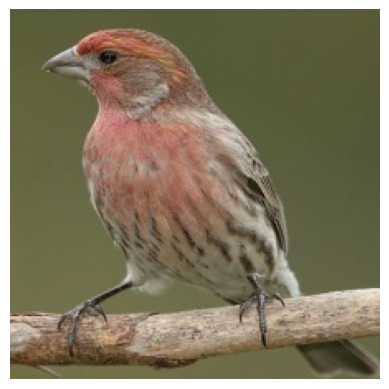

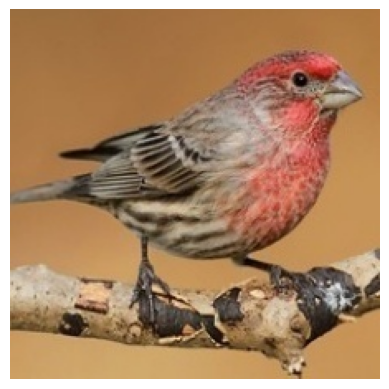

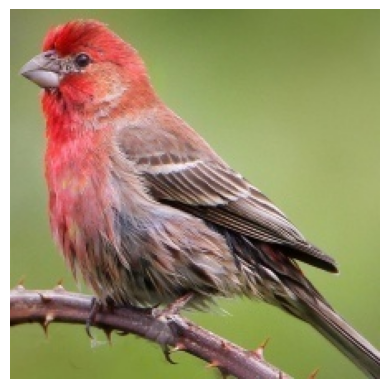

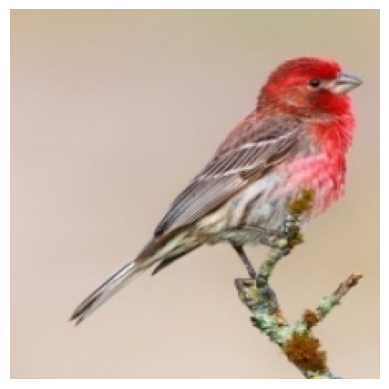

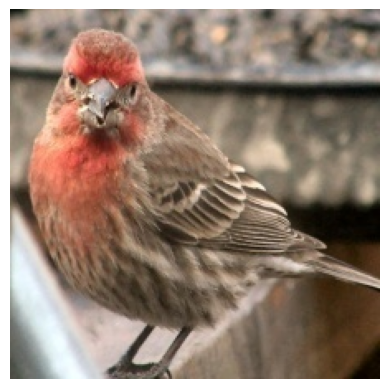

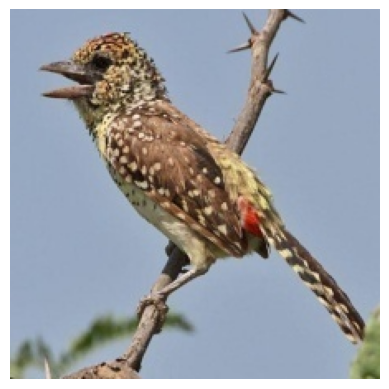

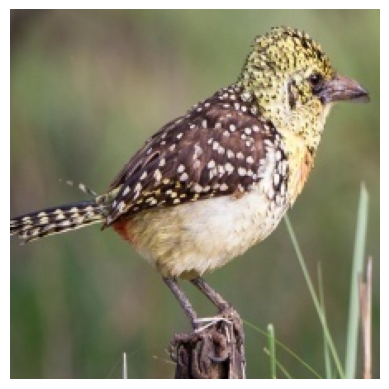

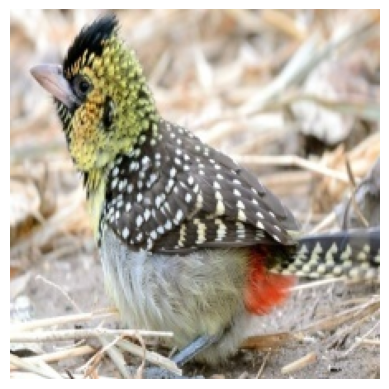

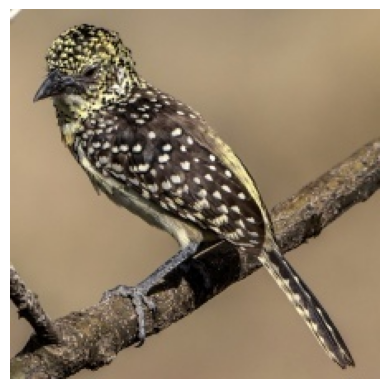

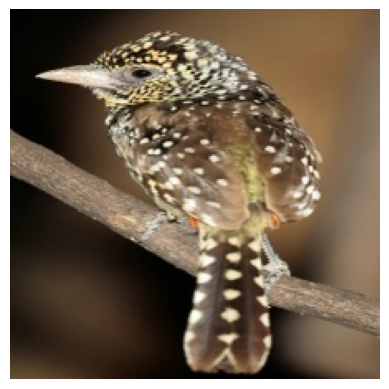

In [110]:

# I iterate through each index of misclassified instances in the test dataset
for index in misclassified_indices:
    # I retrieve the file path of the misclassified image from the test dataset using its index
    img_path = test_generator.filepaths[index]
    
    # I read the image using matplotlib's imread function
    img = plt.imread(img_path)
    
    # I display the misclassified image using matplotlib's imshow function
    plt.imshow(img)
    
    # I turn off axis labels and ticks for better visualization
    plt.axis('off')
    
    # I show the image plot
    plt.show()
